In [66]:
import math
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.stats as ss
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

Download the dataset from kaggle (https://www.kaggle.com/spscientist/students-performance-in-exams) using the following command in the `interpretability/data` folder.
```
kaggle datasets download -d spscientist/students-performance-in-exams
```
Extract the zipped file and then you're good to go!

In [2]:
df = pd.read_csv('data/students-performance-in-exams/StudentsPerformance.csv')

In [3]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
len(df)

1000

# Helper Functions

In [54]:
def score_to_grade(score):
    if score >= 80:
        return 'A'
    if score >= 60:
        return 'B'
    if score >= 45:
        return 'C'
    if score >= 40:
        return 'D'
    return 'F'

In [77]:
# Source: https://github.com/shakedzy/dython/blob/master/dython/nominal.py
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """

    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        f, ax = plt.subplots(figsize=kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'))
        return f, ax
    if return_results:
        return corr

# Exploratory Analysis

In [5]:
df['gender'].value_counts() / len(df) * 100

female    51.8
male      48.2
Name: gender, dtype: float64

In [6]:
df['race/ethnicity'].value_counts() / len(df) * 100

group C    31.9
group D    26.2
group B    19.0
group E    14.0
group A     8.9
Name: race/ethnicity, dtype: float64

In [7]:
df['parental level of education'].value_counts() / len(df) * 100

some college          22.6
associate's degree    22.2
high school           19.6
some high school      17.9
bachelor's degree     11.8
master's degree        5.9
Name: parental level of education, dtype: float64

In [8]:
df['lunch'].value_counts() / len(df) * 100

standard        64.5
free/reduced    35.5
Name: lunch, dtype: float64

In [9]:
df['test preparation course'].value_counts() / len(df) * 100

none         64.2
completed    35.8
Name: test preparation course, dtype: float64

In [10]:
df['math score'].describe()

count    1000.00000
mean       66.08900
std        15.16308
min         0.00000
25%        57.00000
50%        66.00000
75%        77.00000
max       100.00000
Name: math score, dtype: float64

In [11]:
df['reading score'].describe()

count    1000.000000
mean       69.169000
std        14.600192
min        17.000000
25%        59.000000
50%        70.000000
75%        79.000000
max       100.000000
Name: reading score, dtype: float64

In [12]:
df['writing score'].describe()

count    1000.000000
mean       68.054000
std        15.195657
min        10.000000
25%        57.750000
50%        69.000000
75%        79.000000
max       100.000000
Name: writing score, dtype: float64

In [25]:
df['math grade'] = df['math score'].apply(score_to_grade)
df['reading grade'] = df['reading score'].apply(score_to_grade)
df['writing grade'] = df['writing score'].apply(score_to_grade)

In [26]:
df['math grade'].value_counts() / len(df) * 100

B    48.4
C    24.7
A    19.3
F     4.0
D     3.6
Name: math grade, dtype: float64

In [27]:
df['reading grade'].value_counts() / len(df) * 100

B    49.7
A    24.9
C    20.1
D     2.7
F     2.6
Name: reading grade, dtype: float64

In [28]:
df['writing grade'].value_counts() / len(df) * 100

B    48.4
A    23.5
C    21.1
D     3.8
F     3.2
Name: writing grade, dtype: float64

In [34]:
def get_stats(df, grade_col):
    df_gender = df.groupby(['gender', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_gender = df_gender.rename(columns={'lunch': 'count'})
    df_gender['pc'] = df_gender['count'] / len(df) * 100
    
    df_race = df.groupby(['race/ethnicity', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_race = df_race.rename(columns={'lunch': 'count'})
    df_race['pc'] = df_race['count'] / len(df) * 100
    
    df_parent = df.groupby(['parental level of education', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_parent = df_parent.rename(columns={'lunch': 'count'})
    df_parent['pc'] = df_parent['count'] / len(df) * 100
    
    df_lunch = df.groupby(['lunch', grade_col]).agg({'gender': 'count'}).reset_index()
    df_lunch = df_lunch.rename(columns={'gender': 'count'})
    df_lunch['pc'] = df_lunch['count'] / len(df) * 100
    
    df_test_prep = df.groupby(['test preparation course', grade_col]).agg({'gender': 'count'}).reset_index()
    df_test_prep = df_test_prep.rename(columns={'gender': 'count'})
    df_test_prep['pc'] = df_lunch['count'] / len(df) * 100
    
    return df_gender, df_race, df_parent, df_lunch, df_test_prep

In [80]:
df_gender_math, df_race_math, df_parent_math, df_lunch_math, df_test_prep_math = get_stats(df, 'math grade')
df_gender_reading, df_race_reading, df_parent_reading, df_lunch_reading, df_test_prep_reading = get_stats(df, 'reading grade')
df_gender_writing, df_race_writing, df_parent_writing, df_lunch_writing, df_test_prep_writing = get_stats(df, 'writing grade')

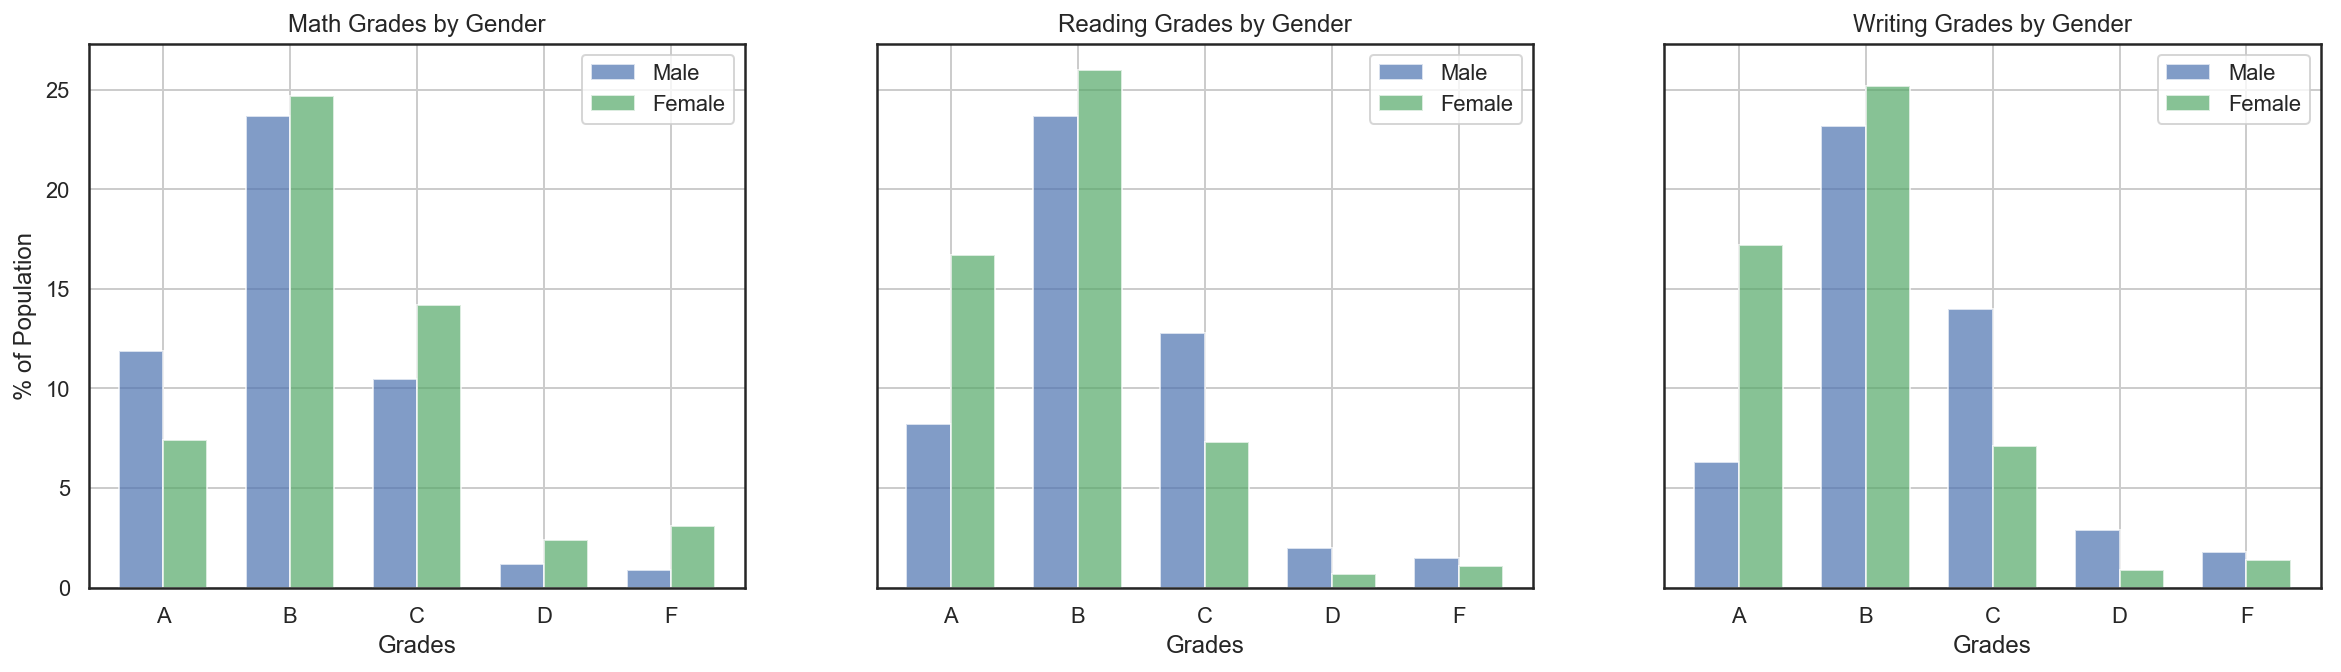

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

grades = ['A', 'B', 'C', 'D', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.7
error_config = {'ecolor': '0.3'}

ax[0].bar(index, df_gender_math[df_gender_math['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[0].bar(index + bar_width, df_gender_math[df_gender_math['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[0].set_xlabel('Grades')
ax[0].set_ylabel('% of Population')
ax[0].set_title('Math Grades by Gender')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

ax[1].bar(index, df_gender_reading[df_gender_reading['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[1].bar(index + bar_width, df_gender_reading[df_gender_reading['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[1].set_xlabel('Grades')
ax[1].set_title('Reading Grades by Gender')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

ax[2].bar(index, df_gender_writing[df_gender_writing['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[2].bar(index + bar_width, df_gender_writing[df_gender_writing['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[2].set_xlabel('Grades')
ax[2].set_title('Writing Grades by Gender')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);
fig.savefig('images/grades_by_gender.png', dpi=200, bbox_inches='tight');

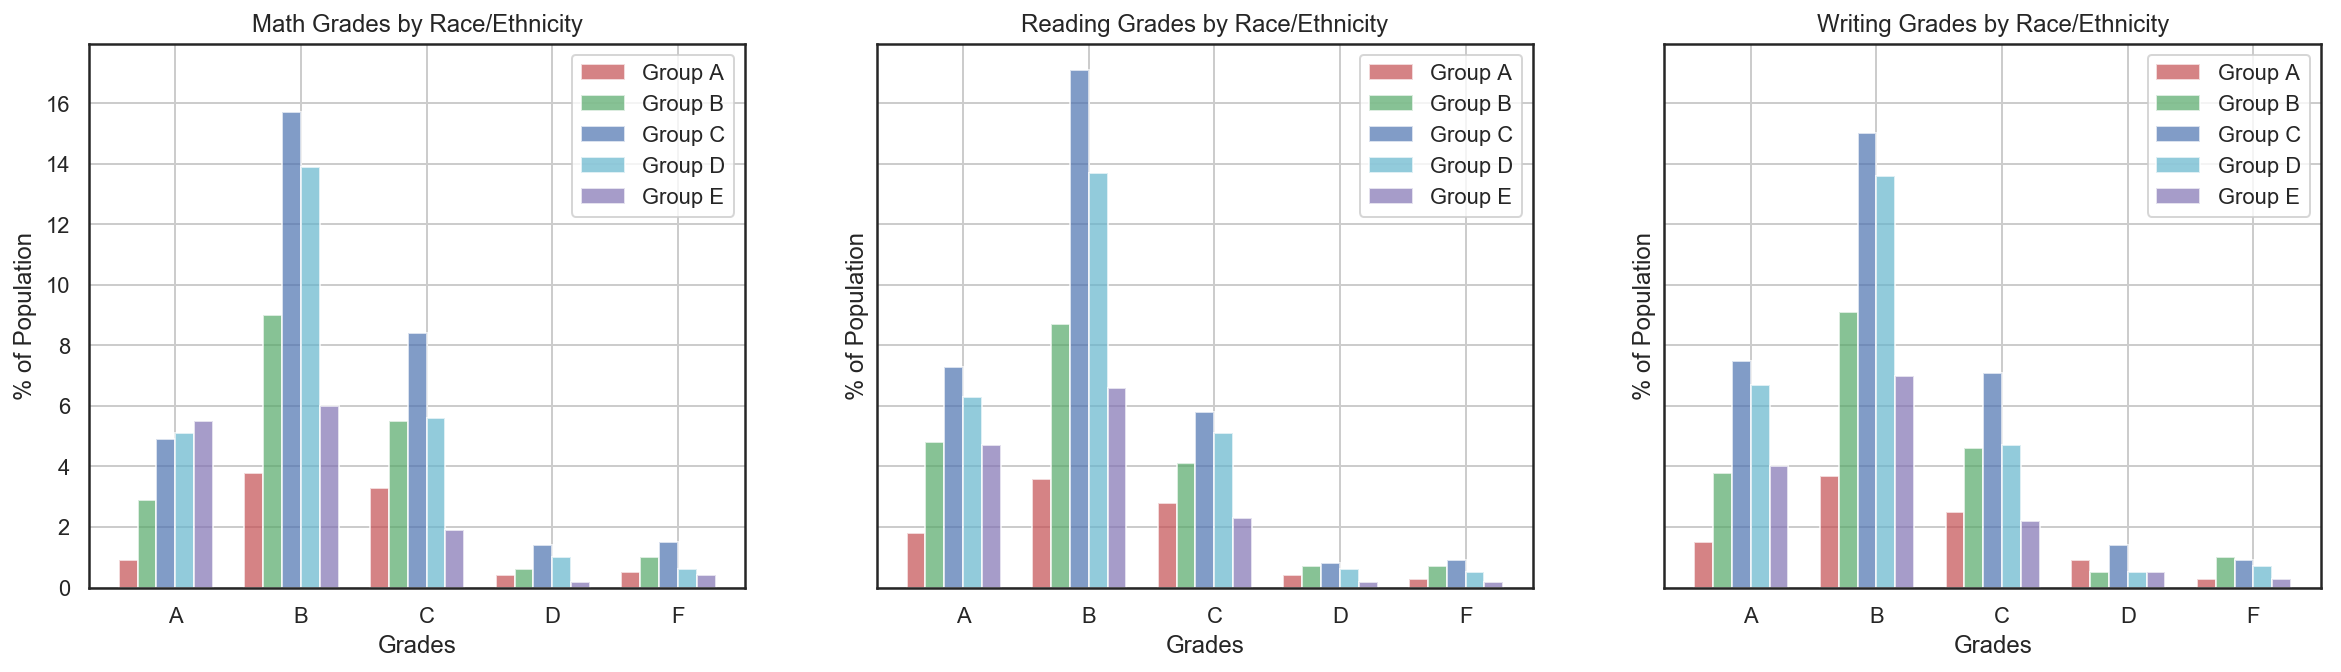

In [113]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

grades = ['A', 'B', 'C', 'D', 'F']
index = np.arange(len(grades))
bar_width = 0.15

opacity = 0.7
error_config = {'ecolor': '0.3'}

ax[0].bar(index, df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'], bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[0].bar(index + bar_width, df_race_math[df_race_math['race/ethnicity'] == 'group B']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Group B')
ax[0].bar(index + bar_width * 2, df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Group C')
ax[0].bar(index + bar_width * 3, df_race_math[df_race_math['race/ethnicity'] == 'group D']['pc'], bar_width,
                alpha=opacity, color='c',
                label='Group D')
ax[0].bar(index + bar_width * 4, df_race_math[df_race_math['race/ethnicity'] == 'group E']['pc'], bar_width,
                alpha=opacity, color='m',
                label='Group E')

ax[0].set_xlabel('Grades')
ax[0].set_ylabel('% of Population')
ax[0].set_title('Math Grades by Race/Ethnicity')
ax[0].set_xticks(index + bar_width * 2.5)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

ax[1].bar(index, df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'], bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[1].bar(index + bar_width, df_race_reading[df_race_reading['race/ethnicity'] == 'group B']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Group B')
ax[1].bar(index + bar_width * 2, df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Group C')
ax[1].bar(index + bar_width * 3, df_race_reading[df_race_reading['race/ethnicity'] == 'group D']['pc'], bar_width,
                alpha=opacity, color='c',
                label='Group D')
ax[1].bar(index + bar_width * 4, df_race_reading[df_race_reading['race/ethnicity'] == 'group E']['pc'], bar_width,
                alpha=opacity, color='m',
                label='Group E')

ax[1].set_xlabel('Grades')
ax[1].set_ylabel('% of Population')
ax[1].set_title('Reading Grades by Race/Ethnicity')
ax[1].set_xticks(index + bar_width * 2.5)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

ax[2].bar(index, df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'], bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[2].bar(index + bar_width, df_race_writing[df_race_writing['race/ethnicity'] == 'group B']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Group B')
ax[2].bar(index + bar_width * 2, df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Group C')
ax[2].bar(index + bar_width * 3, df_race_writing[df_race_writing['race/ethnicity'] == 'group D']['pc'], bar_width,
                alpha=opacity, color='c',
                label='Group D')
ax[2].bar(index + bar_width * 4, df_race_writing[df_race_writing['race/ethnicity'] == 'group E']['pc'], bar_width,
                alpha=opacity, color='m',
                label='Group E')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population')
ax[2].set_title('Writing Grades by Race/Ethnicity')
ax[2].set_xticks(index + bar_width * 2.5)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);
fig.savefig('images/grades_by_race.png', dpi=200, bbox_inches='tight');

In [71]:
gender_le = LabelEncoder()
race_le = LabelEncoder()
parent_le = LabelEncoder()
lunch_le = LabelEncoder()
test_prep_le = LabelEncoder()

gender_le.fit(df['gender'])
race_le.fit(df['race/ethnicity'])
parent_le.fit(df['parental level of education'])
lunch_le.fit(df['lunch'])
test_prep_le.fit(df['test preparation course']);

In [74]:
df['gender_le'] = gender_le.transform(df['gender'])
df['race_le'] = race_le.transform(df['race/ethnicity'])
df['parent_le'] = parent_le.transform(df['parental level of education'])
df['lunch_le'] = lunch_le.transform(df['lunch'])
df['test_prep_le'] = test_prep_le.transform(df['test preparation course'])

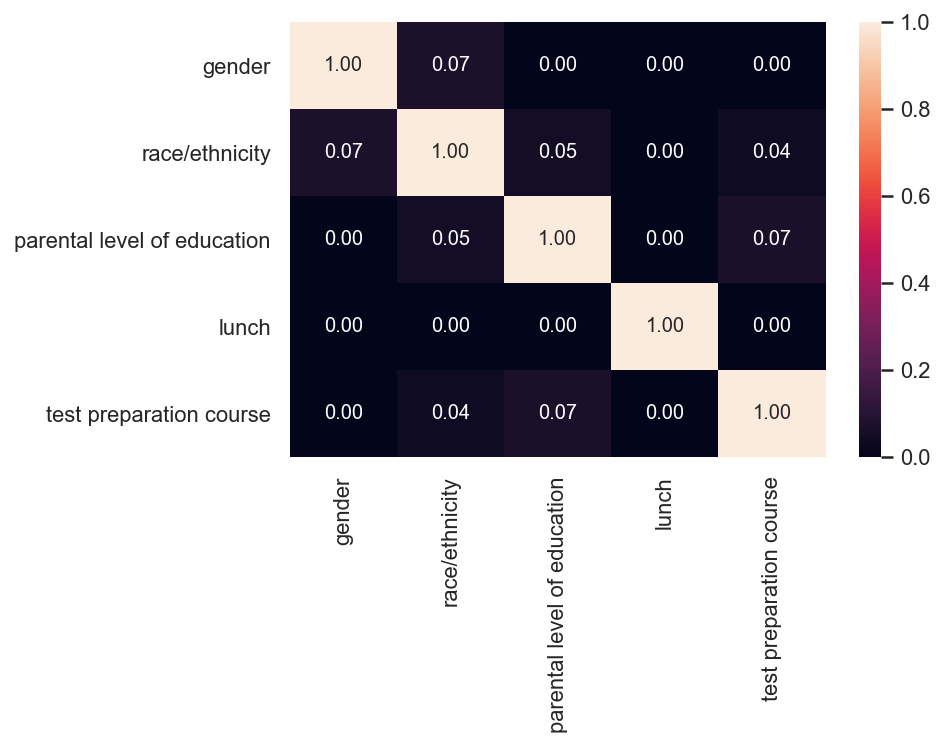

In [79]:
feature_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
f, ax = associations(df[feature_cols], 
             nominal_columns='all', mark_columns=False, theil_u=False, plot=True,
             return_results = False)
f.savefig('images/categorical_correlation.png', dpi=200, bbox_inches='tight')